# 0. IMPORTS

In [115]:
import pandas as pd
import inflection
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from IPython.display import Image
from matplotlib.gridspec import GridSpec
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tabulate import tabulate

## 0.1 Helper Functions

In [2]:
def cramer_v_corr(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1)) # Inserido correções chi2coor, kcorr e rcorr.
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
# O low_memory=False serve para ler o arquivo todo na hora, e não pedaço por pedaço.

df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge - fazendo o merge dos dois arquivos
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# df_sales_raw = o primeiro argumento, o arquivo que vai ser a referência
# df_store_raw = o segundo argumento, o arquivo que será anexado a essa referência
# how='left' = o terceiro argumento, como que eu quero fazer esse merge
# on='Store' = o quarto argumento, a coluna que é igual nos dois datasets, será a chave para o merge

In [4]:
df_raw.sample()
# método que puxa uma linha aleatória do arquivo, para descobrir se ele realmente foi criado

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
447755,311,1,2014-05-26,5802,836,1,0,0,0,a,c,680.0,7.0,2005.0,0,NaN,NaN,NaN


# 1. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()
# Fazer uma cópia do dataset a cada mudança de seção, pois podemos trabalhar em notebooks imensos sem risco de sobreescrever
# os dados originais.

## 1.1 Rename Columns

Para que renomear as colunas? É importante para o cientista de dados localizar facilmente as colunas para realizar o seu trabalho. É possível que algumas colunas nomeadas pelo programador inicial, tenham nomes muito grandes ou que não representam exatamente aquela informação da forma mais adequada para ser trabalhada em uma análise de dados.

In [6]:
df_raw.columns
# Ainda podemos perceber que essa base de dados tem colunas bem nomeadas. Claro que estar no kaggle ajuda nisso.
# No mundo dos negócios real, pode estar mais confuso.

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# Vamos criar a função snakecase para alterar o estilo de escrita das colunas.
# O inflection.underscore(x) deixa todas as letras minúsculas.

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase,cols_old))
# map faz o mapeamento da função snakecase em todas as palavras da lista cols_old
# retorno é uma list() para poder fazer o rename da coluna

# rename
df1.columns = cols_new

In [8]:
# Visualizando o efeito snakecase:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

Saber o tamanho do dataset.

In [9]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

Analisando o tipo de dado de cada coluna.

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

Podemos perceber que a coluna date está em formato object (string). Precisamos mudar isso.

In [11]:
# Vamos sobrescrever a coluna direto:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

Com o comando to_datetime, podemos perceber que agora a coluna date não é mais uma string e agora está em formato datetime64.

## 1.4 Check NA

In [12]:
# Mostra todas as linhas que têm pelo menos uma coluna NA. E soma as linhas por colunas.
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Existem 3 tipos de estratégias para substituir os dados faltantes: eliminar as colunas/linhas com NAs, substituir usando algoritmo de ML que infere valores aos NAs, ou conhecendo do negócio e imputar os valores a partir disso.

## 1.5 Fillout NA

Use a tecla Alt e o mouse para criar um cursor vertical que edita todas as linhas.
Cada coluna deve ser tratada de maneira própria, a partir do entendimento do seu significado. O cientista de dados deve resolver os NAs a partir do entendimento do negócio, a preocupação com o negócio precisa ser chave e bem comunicada com todos.

In [13]:
df1['competition_distance'].max()

75860.0

In [14]:
# competition_distance - Aqui, a estratégia foi colocar um outlier máximo em todos os NAs.

# 200000 if math.isnan(df1['competition_distance']) else df1['competition_distance']

# O lambda x é a mesma coisa que função de x, logo eu posso substituir o df1 por x.
# Aplico em todas as linhas do dataset com o apply.

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

# competition_open_since_month  
# competition_open_since_year   
# promo2_since_week             
# promo2_since_year             
# promo_interval                

Chamando a soma das linhas NAs em cada coluna, percebemos que a coluna competition_distance não tem mais NAs.

In [15]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [16]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
576499,830,5,2014-01-31,6182,514,1,0,0,0,a,c,6320.0,NaN,NaN,1,5.0,2011.0,"Jan,Apr,Jul,Oct"


In [17]:
# competition_open_since_month - Aqui vamos extrair o mês dentro do date para o início da competição.

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
# O axis_1 significa que vou aplicar o comando ao longo das colunas, preciso colocar quando trabalho com mais de uma coluna.

# competition_open_since_year - A mesma lógica, só que em anos. Então vamos copiar a linha de código da coluna anterior
# e substituir o month por year.
# você pode substituir todos os month por year automaticamente colocando a linha em uma célula própria e >>>
# apertando ctrl + shift + p para abrir os comandos rápidos > chegar na função find/replace

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week - nessa e na próxima coluna, vamos operar usando a mesma lógica do competition_open_since_month/year  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year  
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [18]:
# promo_interval - aqui faremos um split dessa coluna, criarei uma lista. Se a data estiver dentro dessa lista, criarei uma 
# coluna falando que a promo2 foi ativa.

# 1 - Vamos criar o dicionário que será usado na futura coluna month_map. Ele substitui o número do mês (que está na coluna 
# date) pela abreviação do mês. 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# 2 - substituir NAs por 0 fazendo modificação direta na coluna
df1['promo_interval'].fillna(0, inplace=True)

# 3 - criação da coluna month_map - números são substituídos pelas letras - aplicando o dicionário criado para fazer a tradução
df1['month_map'] = df1['date'].dt.month.map(month_map)

# 4 - split para quebrar os arrays separados por vírgulas em uma lista para ver se o mês do month_map está dentro dessa lista.
# Se sim, retorno 1. Apenas para lojas que estão participando da promo2.
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
# o axis_1 é porque eu vou usar mais de uma coluna, aí preciso especificar a direção

In [19]:
df1.sample(5).T

# O ".T" (transposto) troca a visualização do dataset: a linha passa a ser vertical e a coluna fica horizontal.

,418230,585197,977494,82048,523368
store,891,608,425,654,104
day_of_week,7,4,2,2,3
date,2014-06-22 00:00:00,2014-01-23 00:00:00,2013-02-05 00:00:00,2015-05-19 00:00:00,2014-03-19 00:00:00
sales,0,10067,3351,9218,9576
customers,0,995,455,873,1249
open,0,1,1,1,1
promo,0,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,d,c,a


Aqui percebemos a criação das colunas month_map, que extrai o mês da coluna date, e da is_promo, que diz se o mês do month_map caiu em um dos meses da promo_interval (se tiver aderido a ela) ou não.

Se o mês do month_map estiver dentro da lista da promo_interval, coloca-se que tem promoção. Se não tiver, colocamos como 0.

Chamando a soma dos NAs, percebemos que o preenchimento dos NAs está concluído.

In [20]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

Agora vamos olhar como estão os tipos de dados das colunas agora. É possível que algo tenha se alterado nas mudanças feitas até agora.

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

Vamos trocar o tipo de dado dessas colunas de float para int:

In [22]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [23]:
# Trocados!
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

Separando variáveis numéricas de categóricas:

In [24]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [25]:
# Observe como o dataframe num_attributes contém apenas as variáveis numéricas do df1.
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
802346,332,5,3377,475,1,0,0,1840.0,3,2006,0,28,2013,0
507202,663,4,5056,679,1,1,0,7860.0,5,2005,0,14,2014,0


In [26]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
94253,0,a,a,0,May
484277,0,d,a,0,Apr


### 1.7.1 Numerical Attributes

In [27]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T 
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Vou transpor com o .T para facilitar a visualização das métricas

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T 
d2 = pd.DataFrame(num_attributes.apply(min)).T 
d3 = pd.DataFrame(num_attributes.apply(max)).T 
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T # range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index() # m de metrics
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] # naming columns

Agora preciso averiguar se as métricas coletadas fazem sentido para entender o negócio.

In [28]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Figure size 1440x864 with 0 Axes>

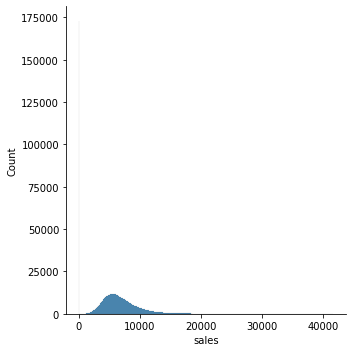

In [29]:
plt.figure(figsize=(20, 12))
sns.displot(df1['sales'])
plt.show()
# A biblioteca seaborn instalada aqui está na versão 0.9. A partir da versão 0.11, a função muda de nome para displot.
# Para saber a versão da biblioteca instalada, é só colocar em um snippet: print(sns.__version__) 

No gráfico percebemos uma alta concentração dos valores, com a mediana um pouco deslocada para a esquerda (para baixo) devido à quantidade de lojas registradas com vendas 0. Tudo isso é corroborado pelos dados da coluna 'sales' no dataframe "m".

Agora vamos analisar a coluna (transformada em atributo e transposta em linha) 'competition_distance':

In [30]:
m.iloc[[7]]

,attributes,min,max,range,mean,median,std,skew,kurtosis
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712


<Figure size 1440x864 with 0 Axes>

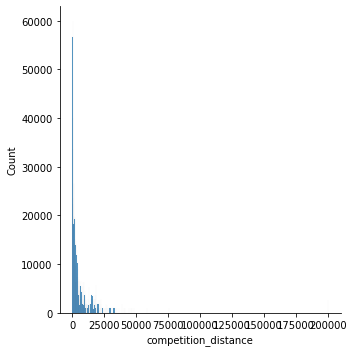

In [31]:
plt.figure(figsize=(20, 12))
sns.displot(df1['competition_distance'])
plt.show()

Range grande, skew muito para a esquerda (mediana bem abaixo da média) e kurtosis bem alto (grande pico): as lojas, em sua grande maioria, estão a uma distância muito pequena umas das outras. Apenas algumas estão distantes.

### 1.7.2 Categorical Attributes

Primeiro vamos olhar quantos níveis cada variável categórica tem:

In [32]:
cat_attributes.apply(lambda x: x.unique().shape[0])
# assortment significa mix de variedade de produtos
# vamos estudar basicamente state_holiday, store_type e assortment

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

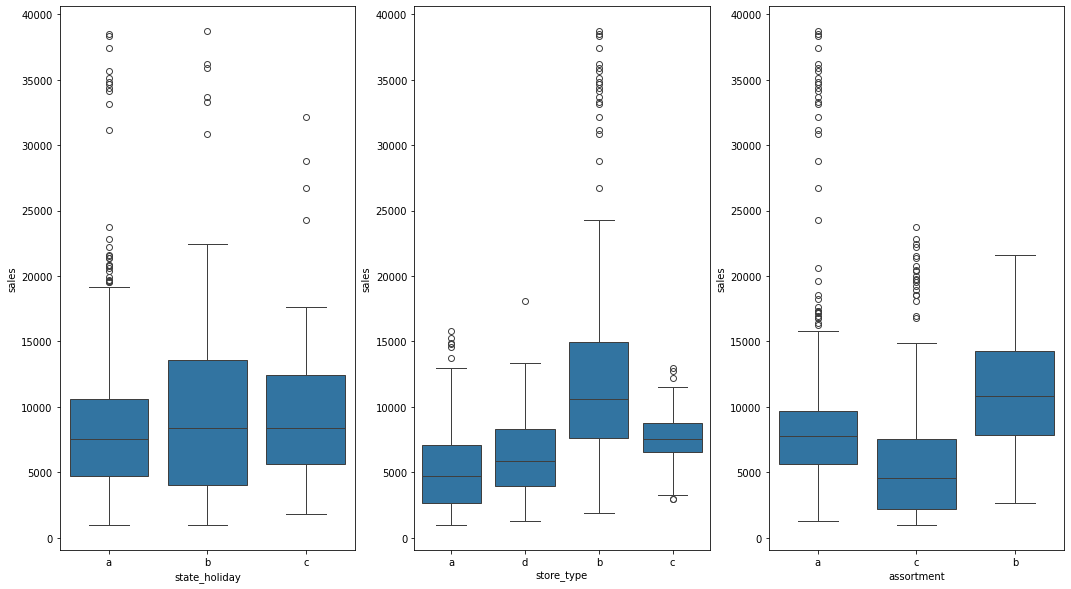

In [33]:
plt.figure(figsize=(18, 10))

# Vamos analisar as vendas por feriado em que as lojas abriram. Para isso tenho que colocar duas condicionais:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
# o state_holiday não deve ser 0 (condição onde não é feriado). Atenção: O '0' está entre apóstrofes porque é uma string.
# Se ele fosse colocado sem as apóstrofes, a condição 0 continuaria aparecendo no gráfico.
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)
# x é a linha que vai ficar como referência, o nome da categoria (variável categórica)
# y é o que eu quero medir (variável numérica)
# nesse primeiro boxplot, eu quero saber como está a dispersão das vendas em cada um dos níveis da variável categórica

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# plt.xlabel("state_holiday", fontsize=20) 
# plt.ylabel("Sales", fontsize=20) 
# plt.xticks(fontsize=18)  
# plt.yticks(fontsize=18)
# plt.show()

In [34]:
# Esclarecendo e analisando os gráficos: 
# 1 - As retas que cortam os retângulos coloridos são as medianas.
# 2 - As partes de cima e de baixo das medianas (as duas partes dos retângulos) são o segundo e o terceiro quartis.
# 3 - As partes acima e abaixo dos retângulos coloridos até as linhas são o primeiro e o quarto quartis.
# 4 - Os pontos acima ou abaixo das linhas (geralmente acima) são os outliers, com valores 3X acima do desvio padrão.
# 5 - Dados como o store_type c mostram um grande pico de concentração.
# 6 - Dados como o store_type b mostram uma grande dispersão, principalmente no primeiro e segundo quartis. 

# 2. FEATURE ENGINEERING

In [35]:
df2 = df1.copy()

## 2.1 Mind Map Hypotheses

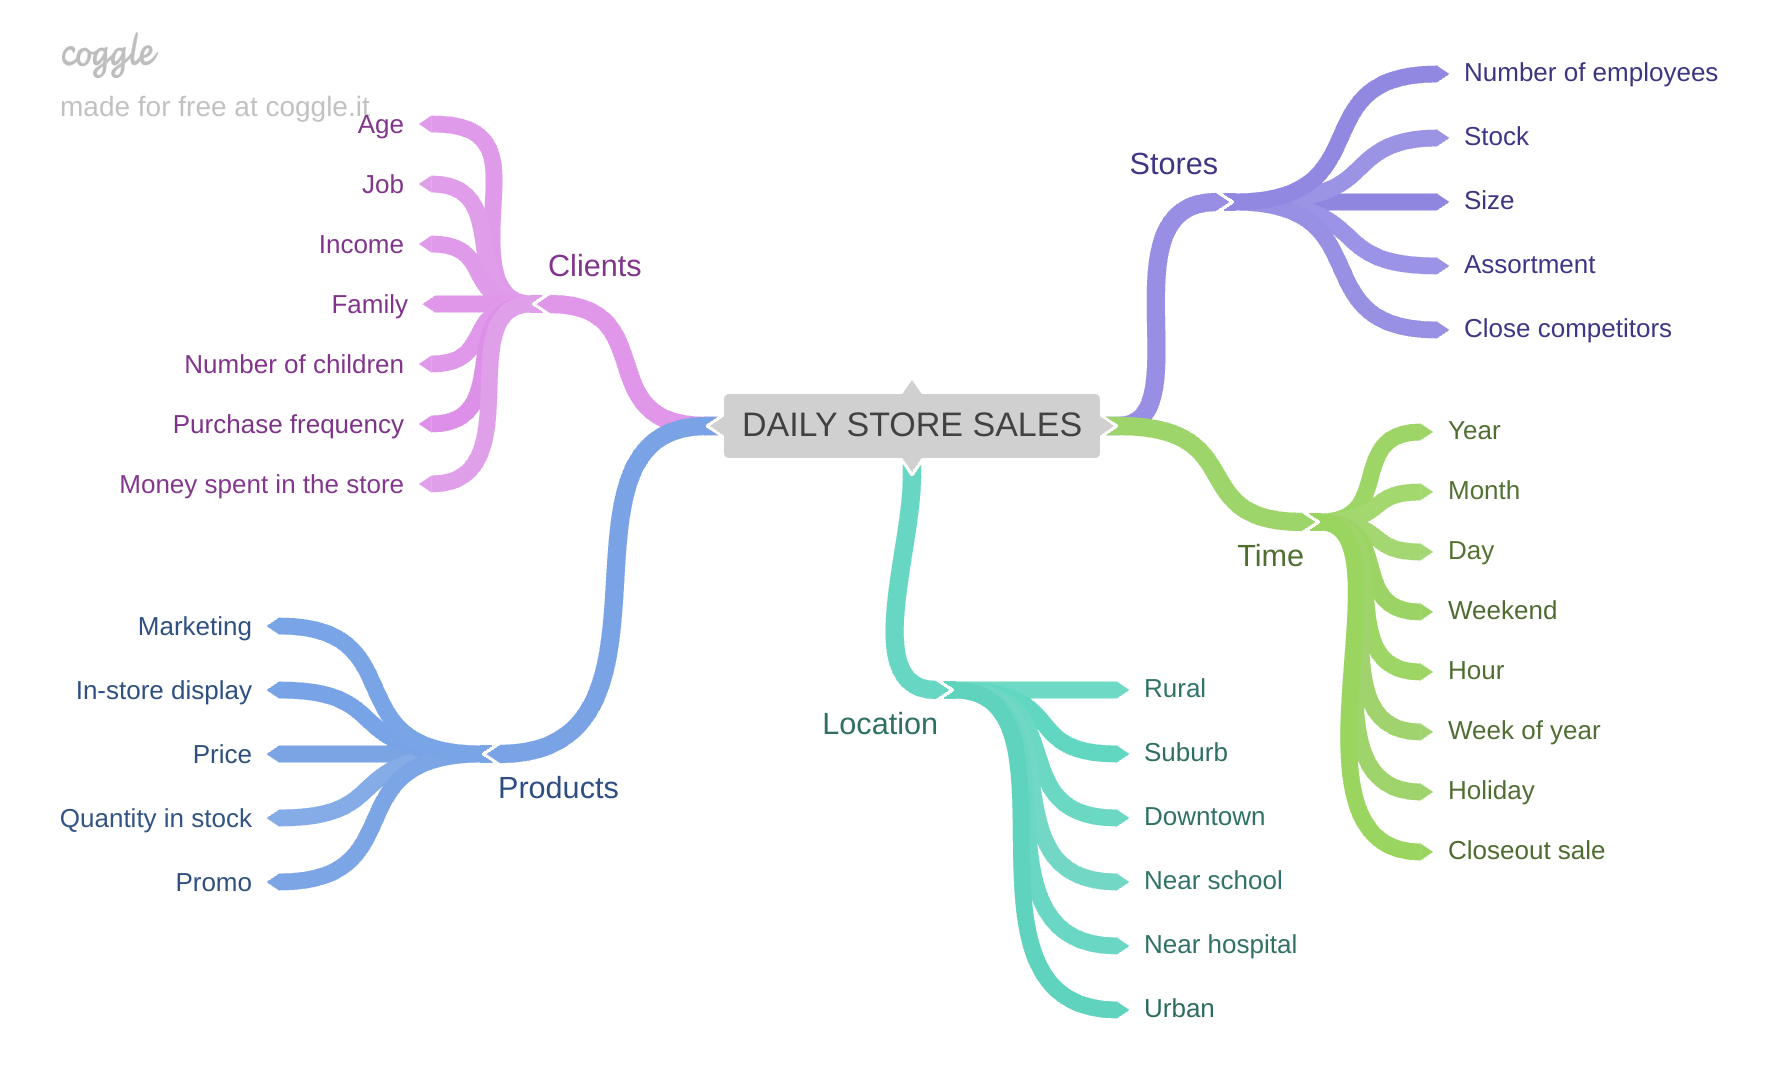

In [36]:
Image('img/MindMapHypothesis.png')

## 2.2 Creating Hypotheses

No mundo corporativo, a criação de hipóteses geralmente acontece em uma reunião de brinstorming com pessoas de todos os times e partes que se relacionam com o fenômeno observado.

### 2.2.1 Hypotheses Related to Stores

**1.** Lojas com maior número de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores há mais tempo deveriam vender mais.

### 2.2.2 Hypotheses Related to Products

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos nas vitrines deveriam vender mais.

**3.** Lojas que têm preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Temporal Hypotheses 

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos nos feriados escolares.

## 2.3 Final List of Hypotheses

Priorização das hipóteses.

**Hypotheses Related to Stores**

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos nos feriados escolares.

## 2.4 Feature Engineering

- Derivação das variáveis de ano, mês, dia e semana do ano.

In [37]:
# year
df2['year'] = df2['date'].dt.year 

# month
df2['month'] = df2['date'].dt.month 

# day
df2['day'] = df2['date'].dt.day 

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week 

# year week - configurando formatação da data
df2['year_week'] = df2['date'].dt.strftime('%Y-%W') 

- Derivação da variável competition_since: precisamos juntar as informações das colunas competition_open_since_month e competition_open_since_year em formato datetime, e do resultado fazer uma subtração da coluna date com ela.

In [38]:
# competition since 
df2['competition_since'] = df2.apply(
    lambda x: datetime.datetime(
        year=x['competition_open_since_year'], 
        month=x['competition_open_since_month'], 
        day=1
    ), axis=1
)
# Observação 1 - como essa função será aplicada em todas as linhas do dataframe, uso lambda x e apply.
# Observação 2 - como não temos o dia do mês de início de cada promoção, uso o dia 1 como padrão.
# Observação 3 - axis=1 significa que o código será aplicado linha a linha (e não coluna a coluna) e é necessário justamente 
# porque o lambda precisa acessar múltiplas colunas da mesma linha para construir a data (aqui 2 colunas).
# "datetime.datetime": porque o método datetime vem da classe datetime.

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']).apply(lambda x: x.days / 30)).astype(int)
# Aqui calculamos o número de meses decorrido do início da competição em cada loja. Precisamos diminuir o date (presente) do
# competition_since (passado) e aplicar o lambda x: x.days para extrair o número de dias, mas dividir por 30 para chegar 
# ao número de meses (existem outras formas de fazer isso), e transformar o resultado em int (pois o formato desse tipo de 
# operação entre datetimes é deltatime).

- Derivação da variável promo since: estratégia semelhante à da competition since, com algumas modificações devido à promo ter apenas os dados do ano e da semana do ano.

In [39]:
# promo since - primeiro vamos juntar as informações que temos nas colunas, e depois converter para data
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# "'-'" é sobre a formatação da data, para ficar ano - semana do ano.
# A transformação das colunas em string é necessária para possibilitar essa formatação. Depois será convertido em data.

df2['promo_since'] = df2['promo_since'].apply(
    lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7)
)
# Aqui estamos sobrescrevendo a própria coluna promo_since, convertendo a data string para datetime.
# A função strptime "entende" a data escrita como texto (string) e a converte em datetime.
# O x + '-1' adiciona o dia da semana %w '-1' (que no caso é segunda-feira) ao final da string
# O '%Y-%W-%w' diz como a data informada será compreendida em datetime.
# %W = semana do ano
# %w = semana de domingo a domingo
# O "- datetime.timedelta(days=7)" subtrai 7 dias para fornecer uma data adequada.
# O timedelta é uma classe do módulo datetime que representa um intervalo de tempo com duração: dias, horas, minutos, etc.

df2['promo_time_week'] = (df2['date'] - df2['promo_since']).apply(lambda x: x.days / 7).astype(int)
# Aqui calculo o tempo que a promoção está ativa em semanas.

- Derivação de varáveis objeto: assortment e state_holiday

In [40]:
# assortment - vamos substituir as letras a/b/c pelo que ela significa na coluna
# a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

# state holiday
# a = public holiday, b = Easter holiday, c = Christmas
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday'if x == 'a' else 'easter_holiday' if x =='b' else 'christmas' if x=='c' else 'regular_day')

In [41]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3. FEATURE SELECTION

In [42]:
df3 = df2.copy()

## 3.1 Row Selection

In [43]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]
# Vamos considerar apenas lojas que estão abertas E que tiveram vendas.

## 3.2 Column Selection

Colunas já derivadas também entram aqui.

In [44]:
'customers' # Não poderei usar, pois retrata o n. de clientes de apenas 1 dia. Não consigo fazer previsões com ela.
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)
# axis=1 significa que vou deletar as colunas.

# 4. EXPLORATION DATA ANALYSIS

In [45]:
df4 = df3.copy()

In [46]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


## 4.1 Univariate Analysis

### 4.1.1 Response Variable

Aqui assumimos que a variável resposta do dataset é a coluna sales. 

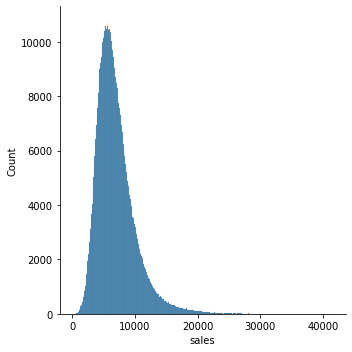

In [47]:
sns.displot(df4['sales']) 

O eixo y do gráfico calcula a densidade de distribuição do fenômeno. 

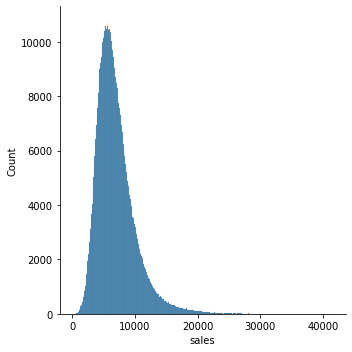

In [48]:
sns.displot(df4['sales'], kde=False) 

O "kde=False" mostra o gráfico como um histograma puro, em que mostra a frequência absoluta do fenômeno.  

### 4.1.2 Numerical Variable

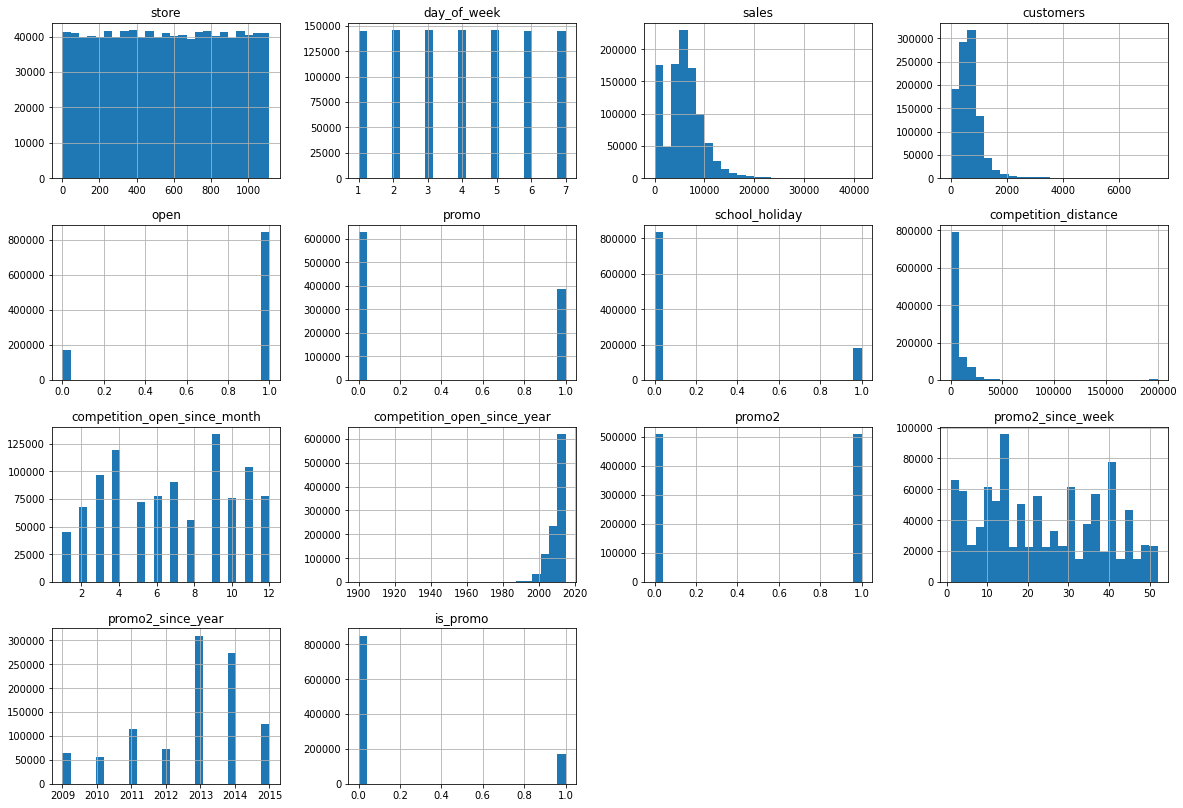

In [49]:
num_attributes.hist(bins=25, figsize=(20, 14));
# O bins=25 significa que cada histograma terá 25 retângulos de amostragem.

- Gráficos com mais comportamento geralmente conseguem explicar mais o fenômeno. Variáveis que têm pouca ou nenhuma variação, não apresentam comportamento, portanto quase não tem informação relevante para explicar o fenômeno e para o desenvolvimento do modelo.

- O ideal é tentar entender e anotar algum possível insight em cada gráfico, como se eu já fosse tentar explicar isso (a relação entre cada variável e a variável-resposta) para alguém.

### 4.1.3 Categorical Variable

In [50]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


Aqui vamos trabalhar as variáveis state_holiday, store_type e assortment. Promo_interval e month_map são variáveis auxiliares que criamos para derivar outras, portanto não serão analisadas.

In [51]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<Axes: xlabel='count', ylabel='state_holiday'>

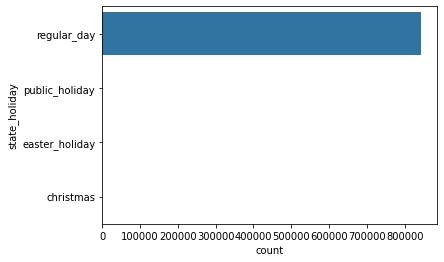

In [52]:
sns.countplot(df4['state_holiday'])

Aqui observamos que as vendas têm um retorno muito maior nos dias regulares que em dias de feriados. Agora vamos tirar a categoria regular_day para comparar as vendas entre os tipos de feriado.

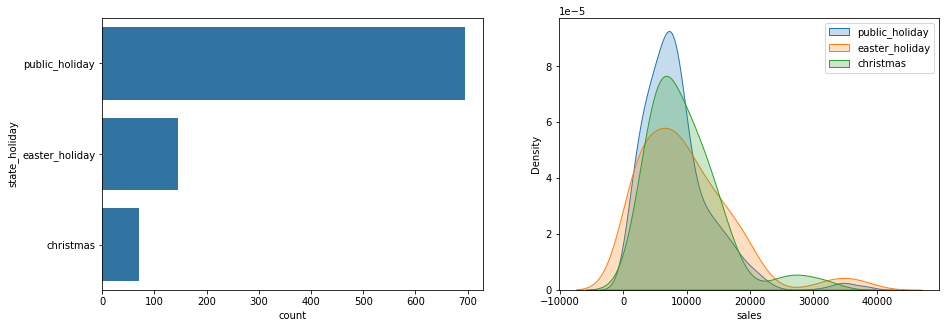

In [53]:
# state_holiday
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1) # O plt.subplot cria uma grade/grid/matriz de gráficos.
a = df4[df4['state_holiday'] != 'regular_day'] 
sns.countplot(a['state_holiday'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True) 
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True) 
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True) 
plt.legend()  
plt.show();
# O fill=True possibilita que cada label apareça com um cor diferente no gráfico.
# O plt.legend() mostra a legenda das cores no gráfico.

No gráfico podemos perceber, por exemplo, que embora o Natal tenha menor quantidade de vendas, ele tem um maior pico de vendas do que no feriado de Páscoa. Insights como esses são importantes para o aprendizado do modelo. Abaixo, vamos para a variável store_type.

In [54]:
# Verificando os tipos de store_type
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

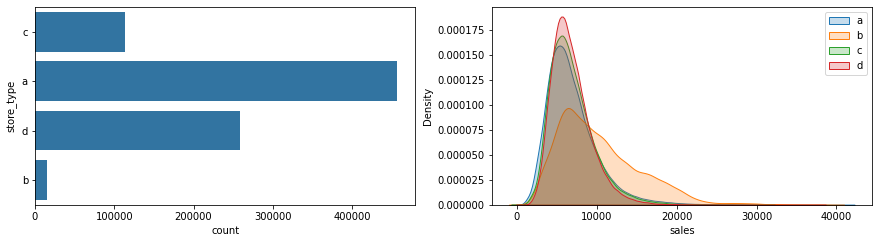

In [55]:
#store_type
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1) 
sns.countplot(df4['store_type'])

plt.subplot(2, 2, 2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True) 
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True) 
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True) 
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
plt.legend()  
plt.show();

A diferença de comportamento entre as alternativas da variável #store_type mostra que ela tem informação relevante para o modelo. Por isso, é importante mantê-la.

In [56]:
# assortment
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

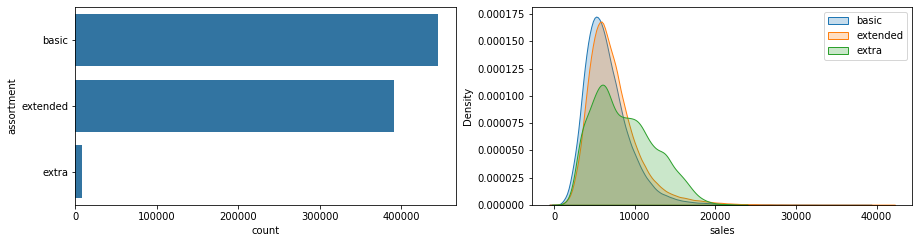

In [57]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1) 
sns.countplot(df4['assortment'])

plt.subplot(2, 2, 2)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True) 
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True) 
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True) 
plt.legend()  
plt.show();

## 4.2 Bivariate Analysis

Para proceder à análise, vamos retornar às hipóteses do mindmap.

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA.** Lojas com MAIOR SORTIMENTO vendem MENOS.

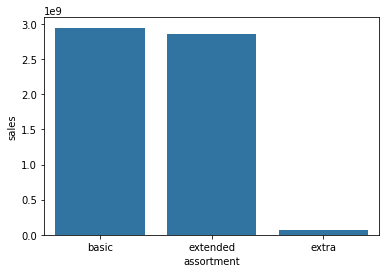

In [58]:
# Variáveis a serem analisadas: assortment e sales.
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

Hipótese falsa - segundo o gráfico, de acordo com o número total de vendas, lojas com tipo de assortment extra vendem bem menos que outros tipos. Mas será que sempre foi assim? 

In [59]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
#sns.barplot(x='assortment', y='sales', data=aux2);

In [60]:
aux2

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693
...,...,...,...
406,2015-29,extended,19570832
407,2015-29,extra,574020
408,2015-30,basic,23492454
409,2015-30,extended,23301780


- Precisamos encontrar uma forma que visualize bem a evolução dos tipos de assortment ao longo do tempo.

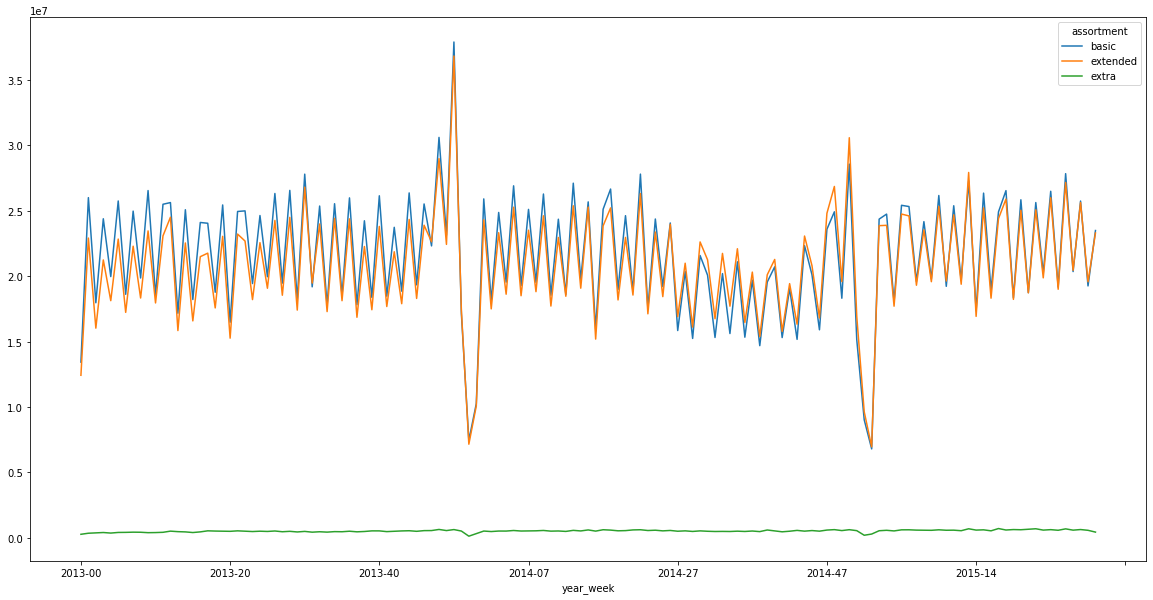

In [61]:
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(20, 10));
# o index é a granularidade das linhas

Vamos filtrar o assortment == extra para aumentar ainda mais o nível de verificação.

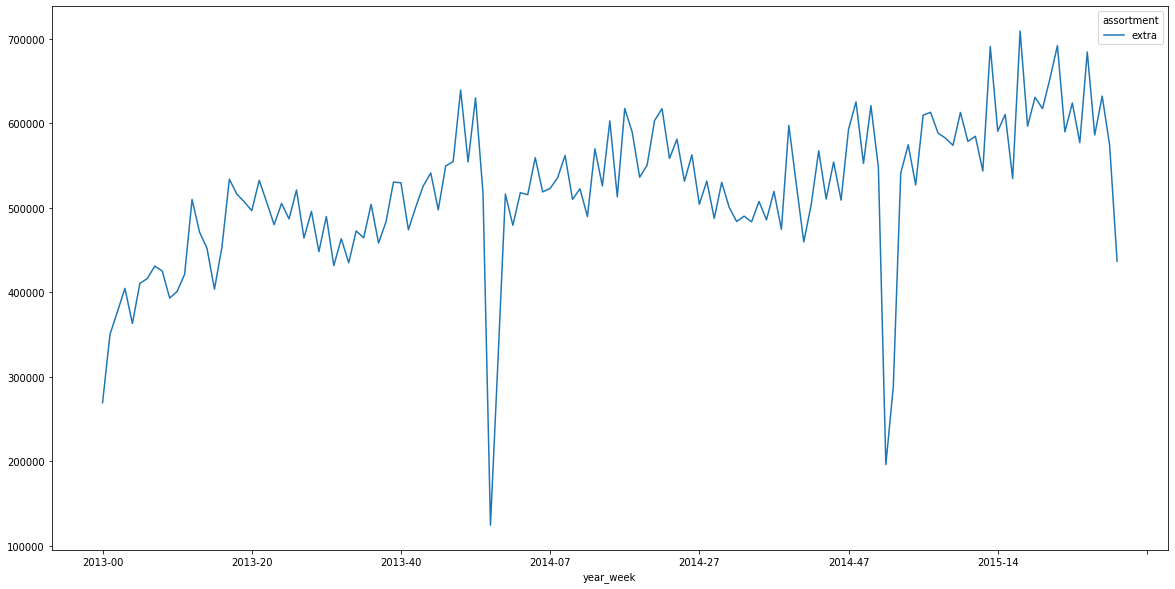

In [62]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(20, 10));

É sempre importante estudar os comportamentos isoladamente! Por exemplo, o tipo assortment extra, ao ser verificado individualmente, revelou um comportamento totalmente diferente, bem menos linear do que quando apareceu no primeiro gráfico!

Resposta da Hipótese 1: FALSA. Lojas com maior sortimento vendem menos.

Em termos de relevância da variável para o modelo. SIM, porque apesar dos tipos basic e extended serem bem similares, o tipo extra é bem diferente.

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA.** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

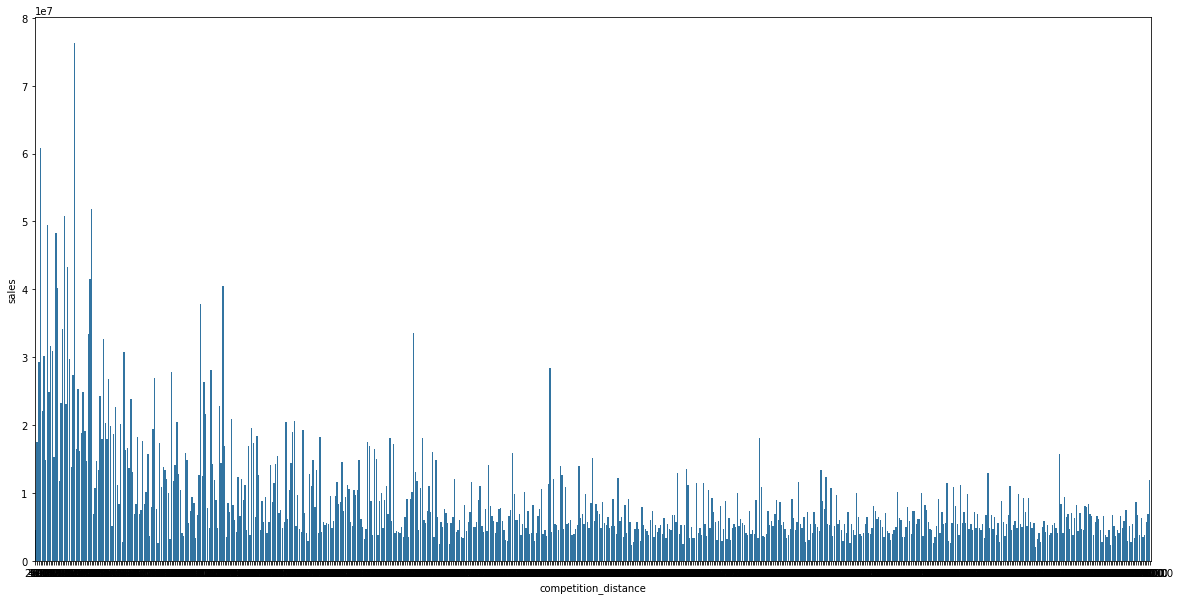

In [63]:
aux1 = df4[['competition_distance', 'sales']].groupby(['competition_distance']).sum().reset_index()
plt.figure(figsize=(20, 10));
sns.barplot(x='competition_distance', y='sales', data=aux1);
plt.show();

Podemos perceber que este é um gráfico muito granular, é difícil obter informações dele. Então precisamos pensar em um método para melhorar a análise. Uma das soluções possíveis é agrupar as diferentes quantidades de competition_distance em níveis de distância. Esse grupo é o famoso bin, a coluna que usamos para criar os histogramas!

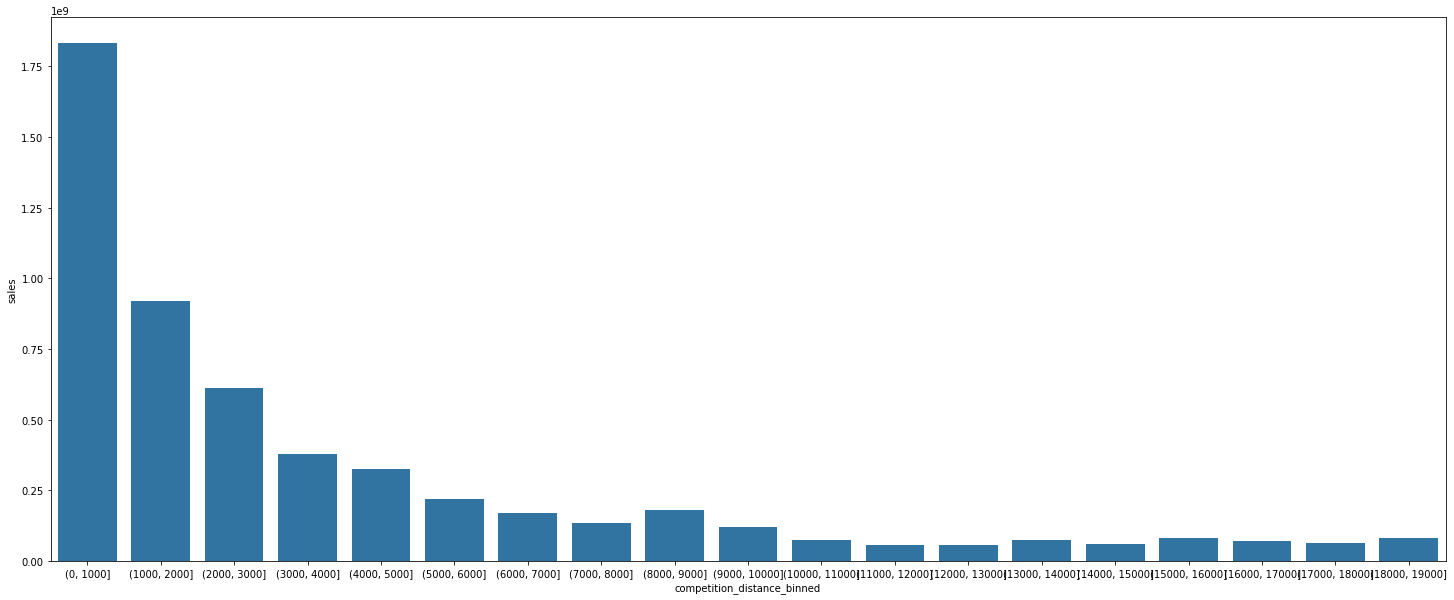

In [64]:
bins = list(np.arange(0, 20000, 1000)) 
# o bins será uma lista que vai de 0 a 20000 e fará os grupos de mil em mil

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins) 
# o pd.cut vai colocar os valores nos seus respectivos grupos, representados na nova coluna competition_distance_binned

# agora vamos somar novamente o número total de vendas por grupo de distância (competition_distance_binned)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby(['competition_distance_binned']).sum().reset_index()
plt.figure(figsize=(25, 10))
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.show();

Através desse gráfico percebemos que a Hipótese 2 também é falsa! Por algum motivo, lojas com concorrentes mais próximos vendem mais! Mas vamos trabalhar a visualização dos dados do competition_distance de outras formas.

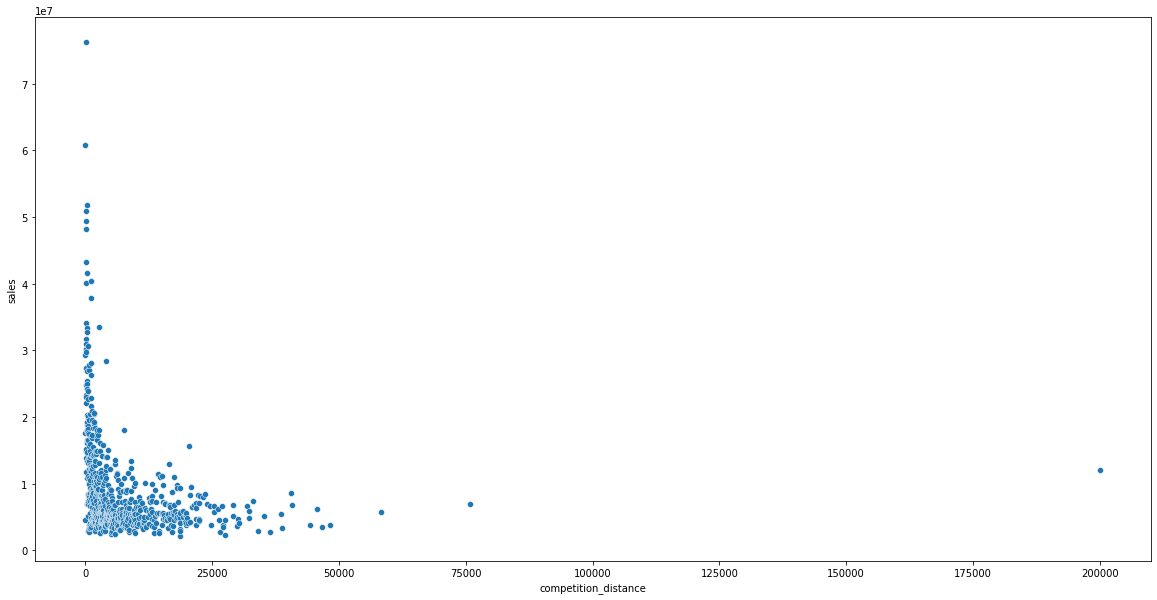

In [65]:
plt.figure(figsize=(20, 10));
sns.scatterplot(x='competition_distance', y='sales', data=aux1);
plt.show();
# com o scatterplot conseguimos visualizar a concentração de dados granulares

Agora vamos criar um gráfico que mede a força da correlação entre competition_distance e vendas, para verificar melhor o impacto da variável competition_distance na variável resposta.

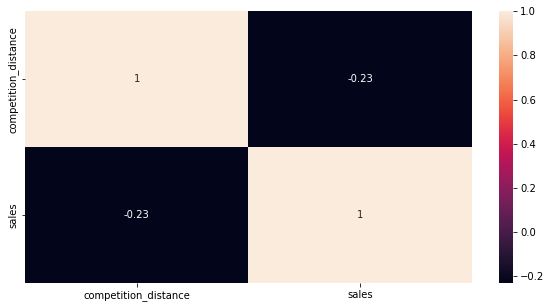

In [66]:
plt.figure(figsize=(10, 5));
sns.heatmap(aux1.corr(method='pearson', numeric_only=True), annot=True);
plt.show();

Quanto mais próximo de 0, mais fraca é a correlação. Quanto mais próximo de +1 ou -1, mais forte é a correlação. Ser um número negativo reforça uma correlação negativa: quanto maior a competition_distance, menor a venda (variável resposta).

### **H3.** Lojas que estão na competição há mais tempo deveriam vender mais.
**FALSA.** Lojas que estão na competição HÁ MAIS TEMPO vendem MENOS.

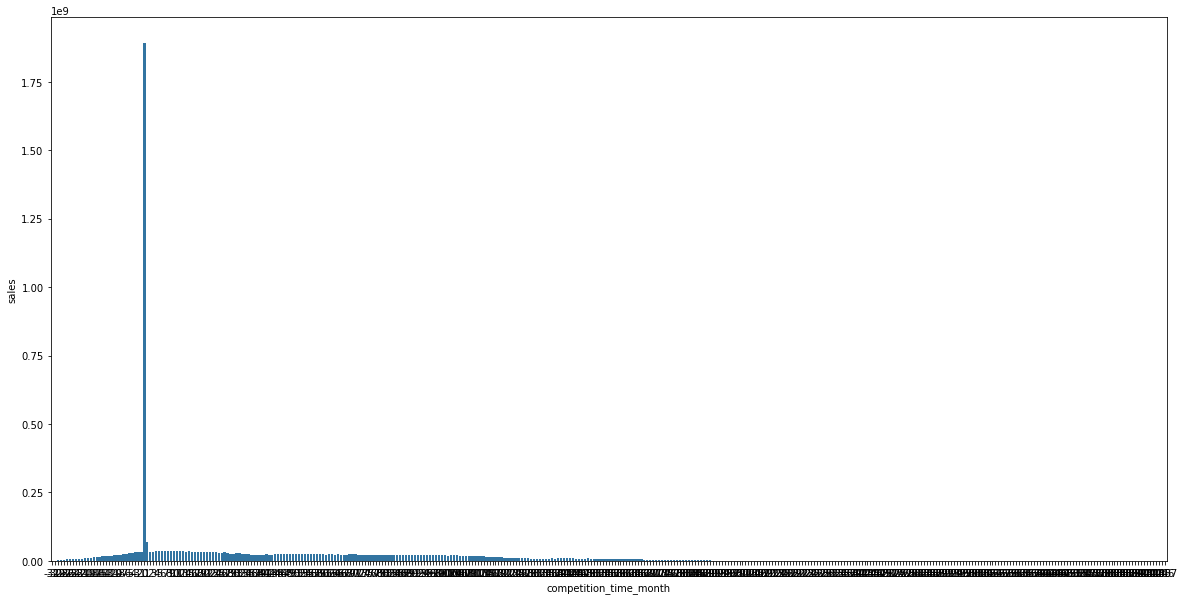

In [67]:
aux1 = df4[['competition_time_month', 'sales']].groupby(['competition_time_month']).sum().reset_index()
plt.figure(figsize=(20, 10));
sns.barplot(x='competition_time_month', y='sales', data=aux1);
plt.show();

Temos um outlier que prejudica a visualização do gráfico. Para resolver isso, vamos aplicar um filtro.

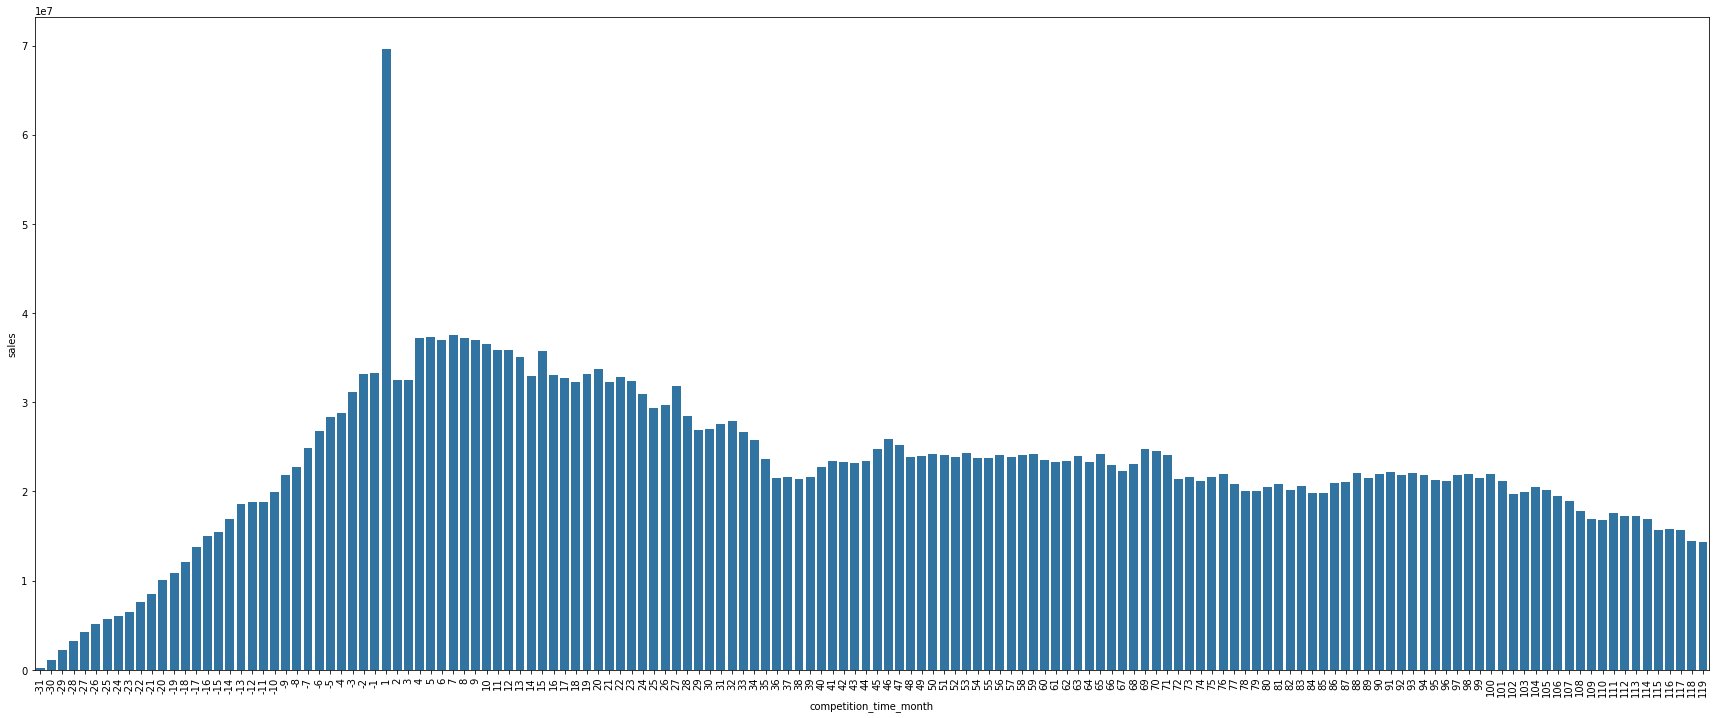

In [68]:
aux1 = df4[['competition_time_month', 'sales']].groupby(['competition_time_month']).sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)] # filtros criados
plt.figure(figsize=(30, 12));
sns.barplot(x='competition_time_month', y='sales', data=aux2); # o data mudou para aux2, considerando os novos filtros
plt.xticks(rotation=90);
plt.show();

Podemos perceber que, quanto mais o competition_time_month se aproxima de 0, maior a quantidade de vendas. 
Isso significa que quanto mais recente a competição, maior é a venda. Aqui já podemos perceber que a Hipótese 3 também é falsa. Agora vamos verificar o impacto dessa variável nas vendas.

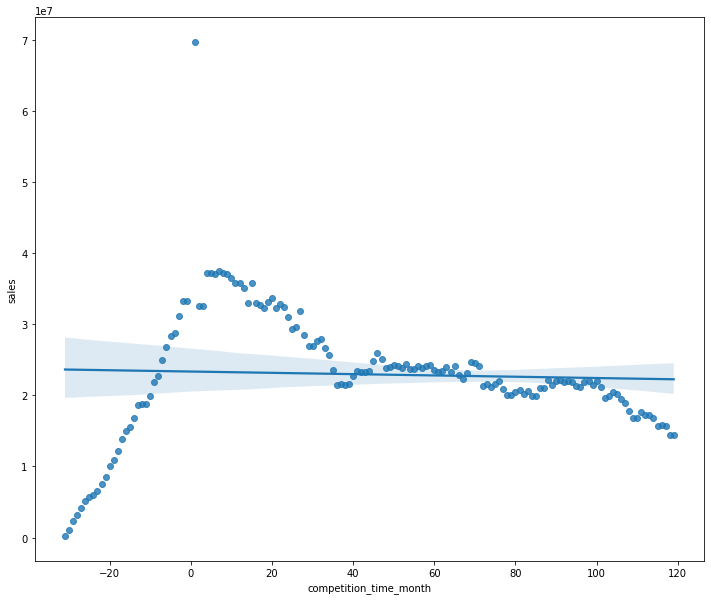

In [69]:
plt.figure(figsize=(12, 10));
sns.regplot(x='competition_time_month', y='sales', data=aux2);
plt.show();

A função sns.regplot revela tendências, ela plota os pontos individuais e ajusta uma linha de regressão linear que mostra a tendência média da relação entre as variáveis. 

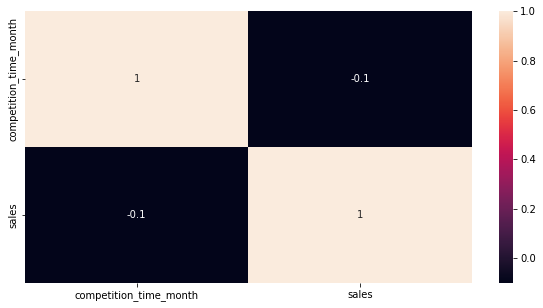

In [70]:
plt.figure(figsize=(10, 5));
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.show();
# Em termos de relevância para o modelo, a competition_time_month ainda é uma variável relevante, pois não é tão próxima de 0.

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA.** Lojas com promoções ativas por MAIS TEMPO vendem MENOS, depois de um certo período de promoção.

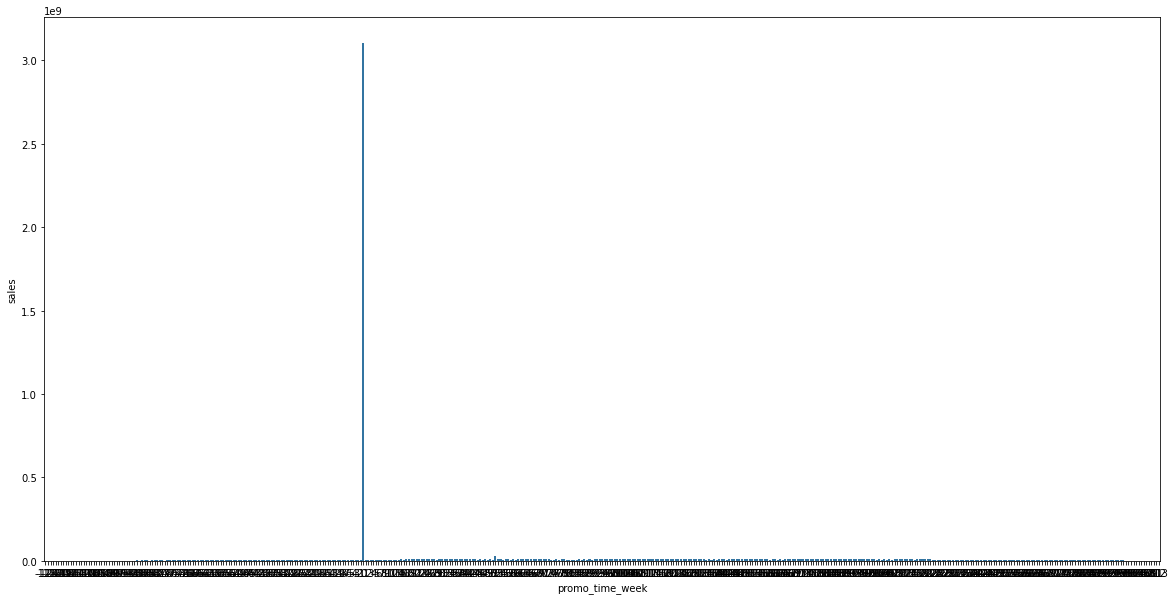

In [71]:
aux1 = df4[['promo_time_week', 'sales']].groupby(['promo_time_week']).sum().reset_index()
plt.figure(figsize=(20, 10));
sns.barplot(x='promo_time_week', y='sales', data=aux1);
plt.show();

Temos um outlier tão imponente no gráfico que nos impede de visualizarmos sua mensagem. Vamos contornar esse problema dividindo esse gráfico em dois, um com o promo_time_week positivo (parte direita) e outro com o negativo (parte esquerda), tirando o promo_time_week = 0 que é o outlier.

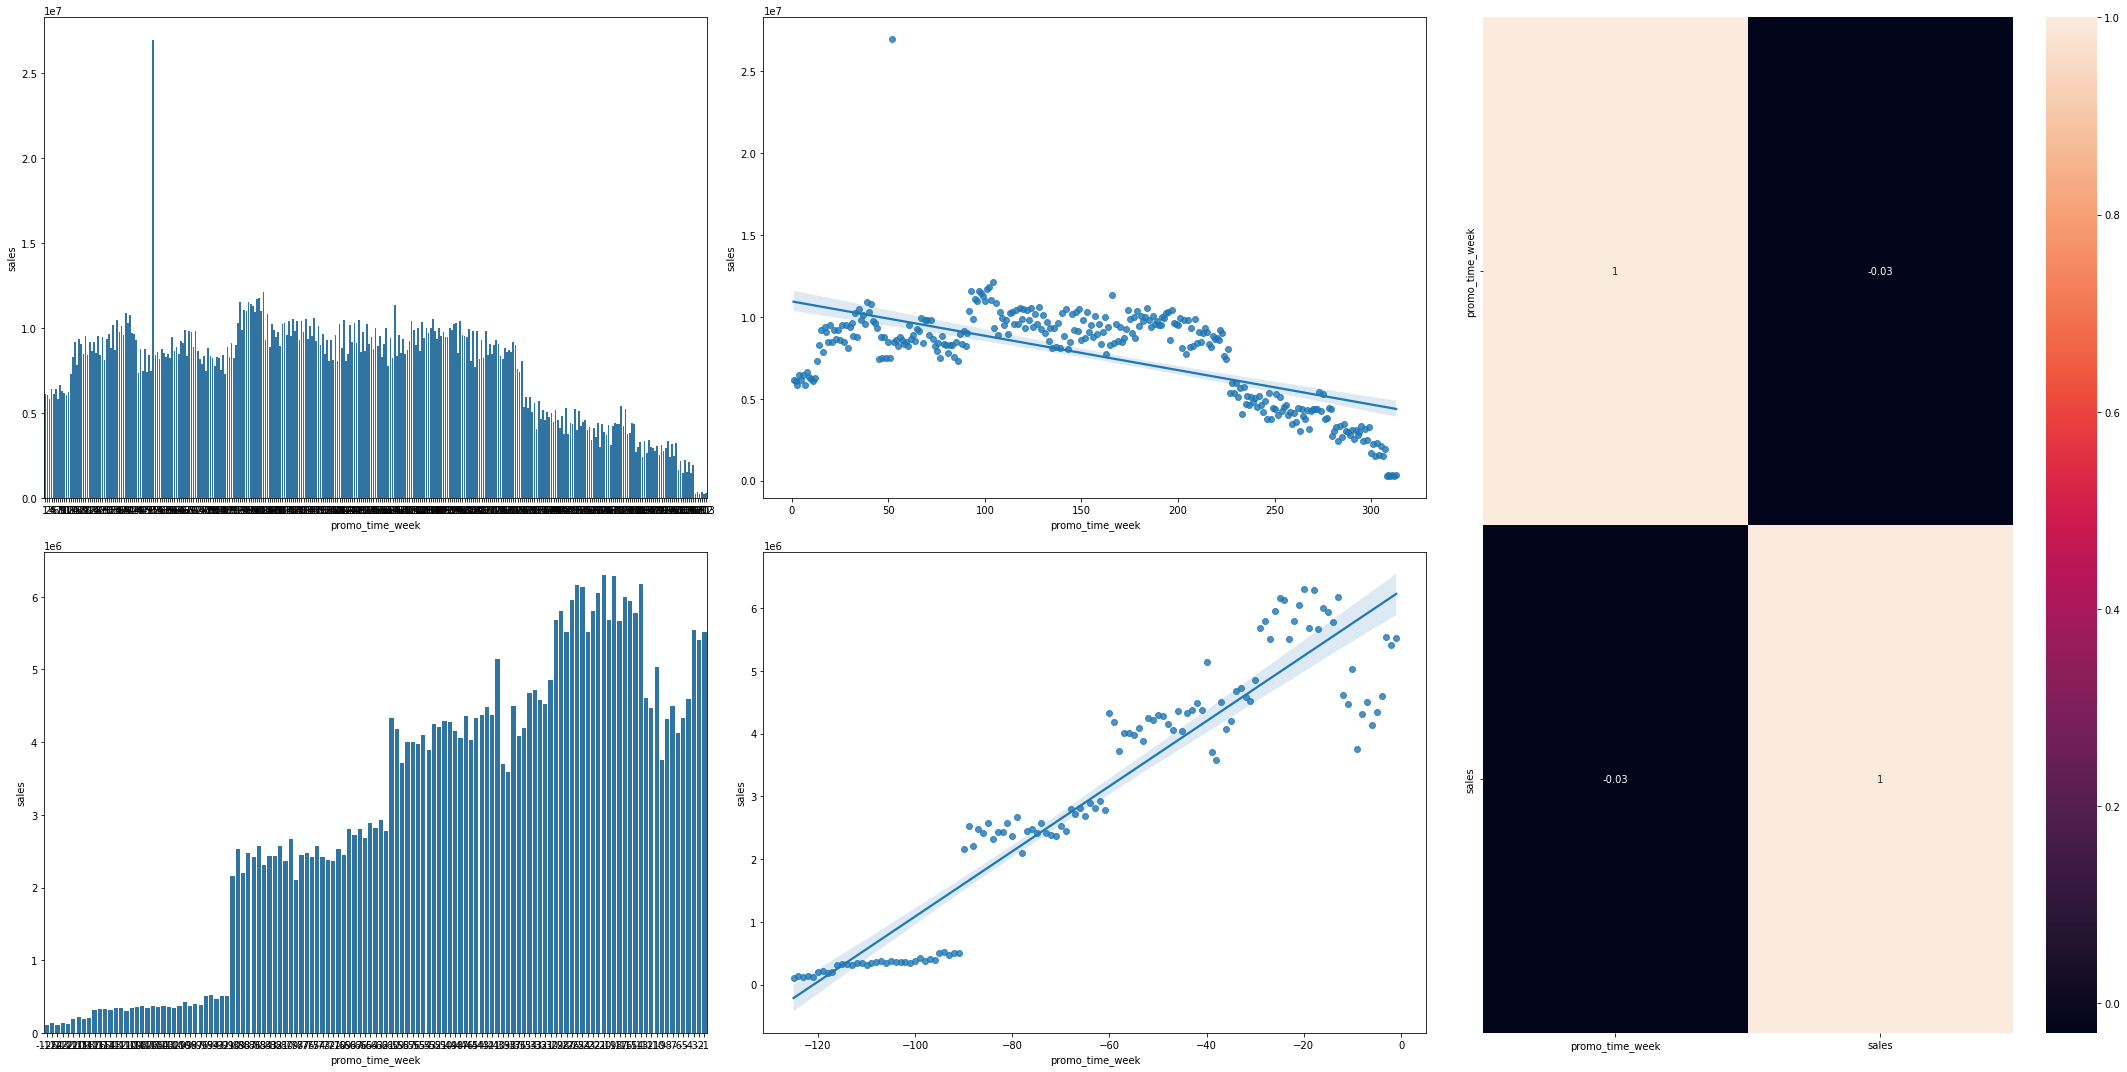

In [72]:
plt.figure(figsize=(30, 15))

grid = GridSpec(2, 3) # Atenção: o GridSpec precisa ser importado.

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido (valores positivos data promo)
sns.barplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[0, 1]) # gráfico de tendência
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True); # calcula correlacao da variavel

plt.tight_layout()  # Evita que os gráficos se sobreponham
plt.show()


Insight extraído: as vendas altas se sustentam por um período após a promoção extendida. Após um pouco mais de 200 semanas, esse efeito passa e as vendas caem, o que faz com que a hipótese 4 também seja falsa. Além disso, a correlação do heatmap ter como resultado -0,03 (bem próximo de 0) mostra que a variável promo_time_week não tem muita relevância no modelo.

###<s> **H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA.** Lojas com mais promoções CONSECUTIVAS vendem MENOS.

In [73]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


Pelo que a tabela nos diz, entrar em promoção extendida não traz vantagens. Agora vamos verificar o comportamento dessa variável ao longo do tempo, ou seja, se lojas que já estavam na promoção tradicional tiveram mudança nas vendas quando entraram na promoção extendida.

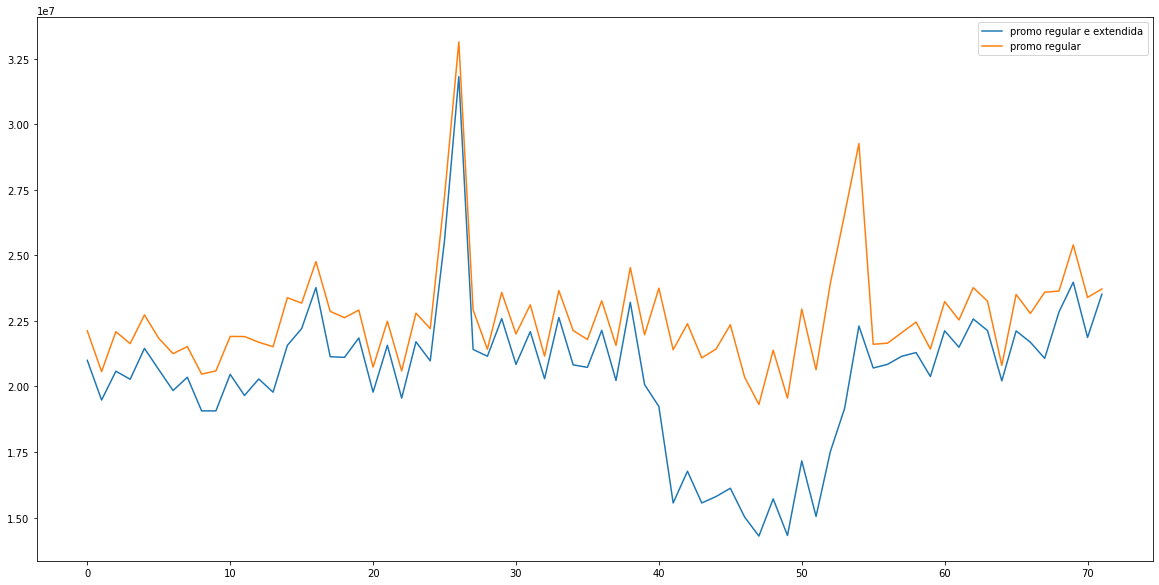

In [74]:
# Verificando o comportamento de vendas das lojas que participaram da promo regular e extendida
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(20, 10));

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(figsize=(20, 10), ax=ax);

ax.legend(labels=['promo regular e extendida', 'promo regular']);

Aqui vemos que as vendas das lojas com promoção regular e extendida acompanham a tendência das lojas apenas com promo regular. Em um período de aproximadamente 10 semanas, as vendas das lojas com promo regular e extendida ficam bem abaixo. Como a linha promo regular e extendida não possui uma variância muito diferente da linha promo, essa variável deve ter pouca relevância para o modelo.

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA.** Lojas abertas durante o feriado de NATAL vendem MENOS.

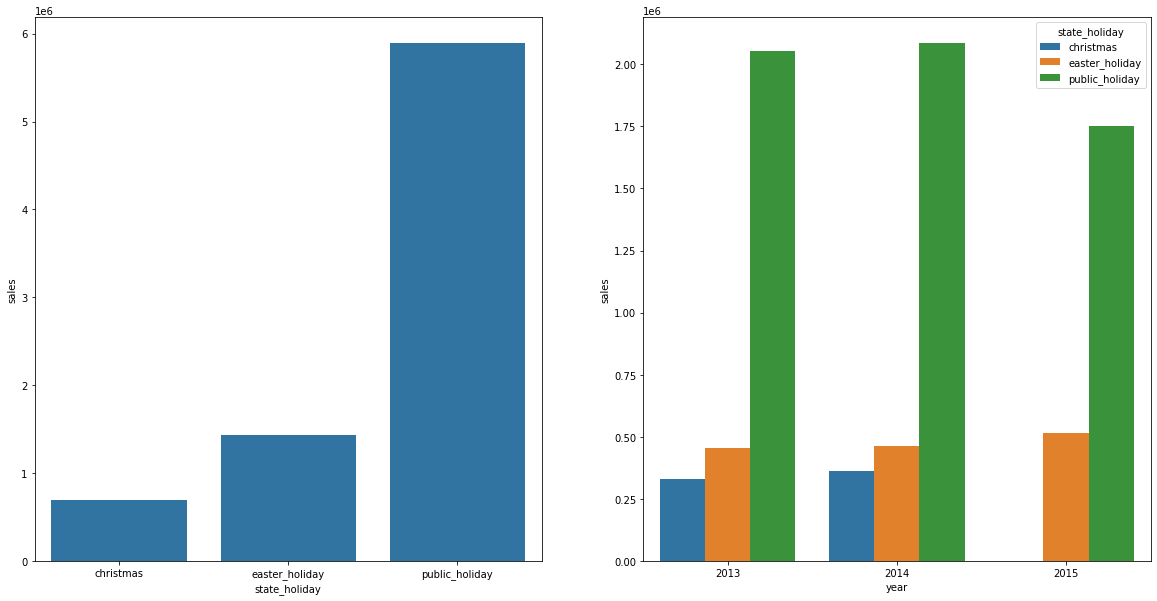

In [75]:
plt.figure(figsize=(20, 10))

aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

# Verificando o comportamento da variável ao longo do tempo
plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);
# O hue cria subgrupos dentro de cada valor do eixo x, adicionando uma dimensão visual extra ao gráfico.

plt.show();

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA.** Lojas vendem MENOS ao longo dos ANOS.

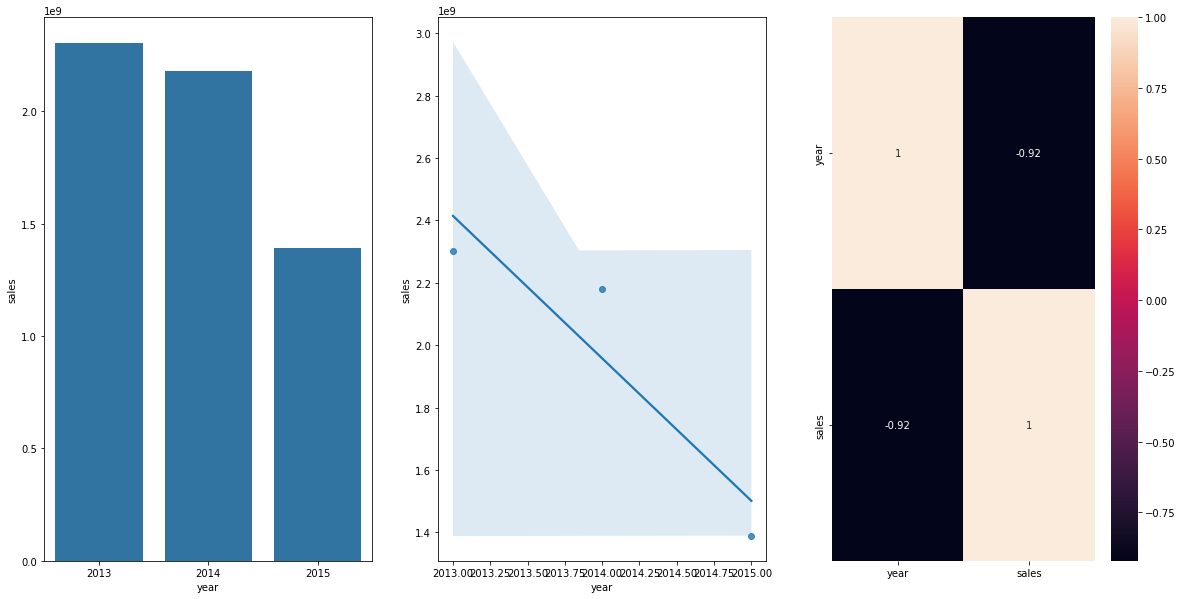

In [76]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA.** Lojas vendem MENOS no segundo SEMESTRE do ano.

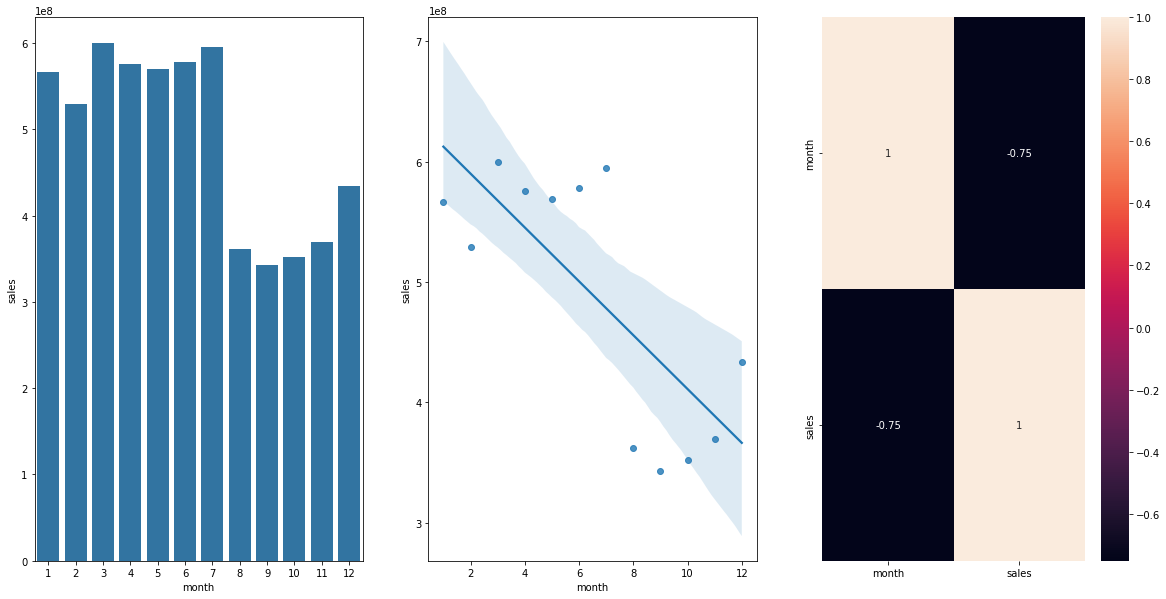

In [77]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA.** Lojas vendem MAIS DEPOIS do dia 10 (mas na média diária vendem MENOS).

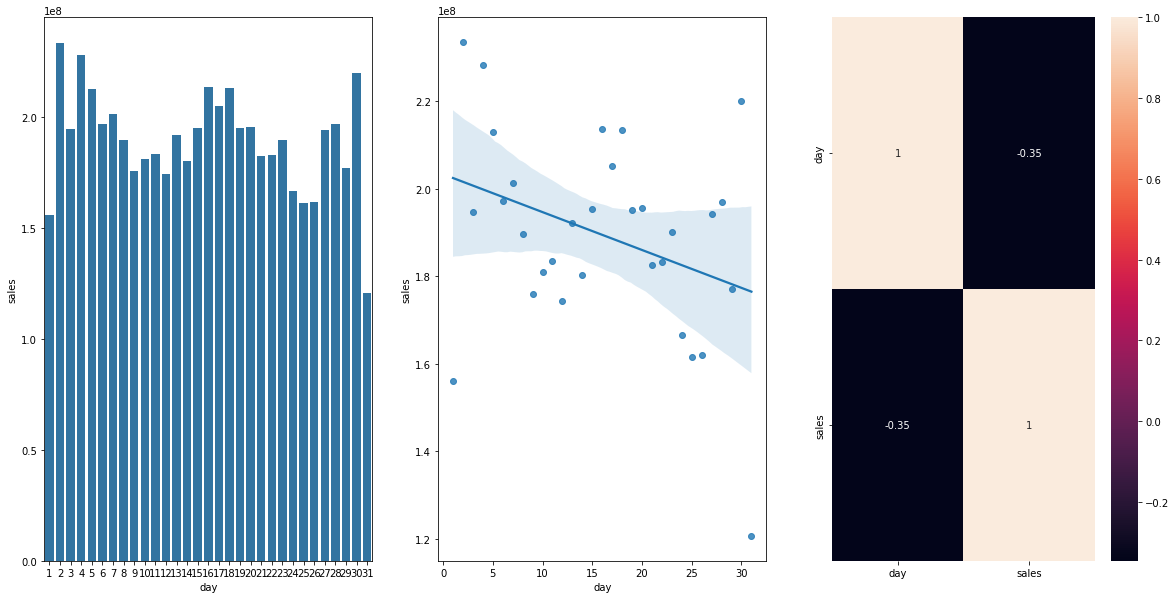

In [78]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

- Vamos aprofundar a análise criando uma nova coluna para o aux1, que irá dividir os meses entre antes e depois do dia 10.

In [79]:
aux1['before_after'] = aux1['day'].apply(lambda x: 'before' if x <= 10 else 'after')
aux1.head(12)

,day,sales,before_after
0,1,155983560,before
1,2,233513169,before
2,3,194582812,before
3,4,228301010,before
4,5,212869176,before
5,6,197094539,before
6,7,201380487,before
7,8,189718770,before
8,9,175922427,before
9,10,181039363,before


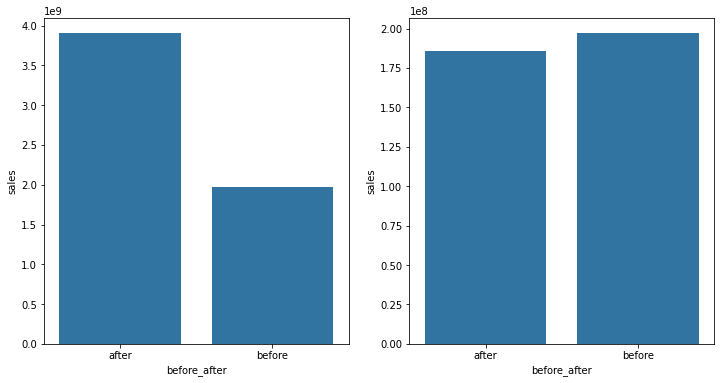

In [80]:
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
aux3 = aux1[['before_after', 'sales']].groupby('before_after').mean().reset_index()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='before_after', y='sales', data=aux2);

plt.subplot(1, 2, 2)
sns.barplot(x='before_after', y='sales', data=aux3);

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRO.** Lojas vendem MENOS nos FINAIS DE SEMANA.

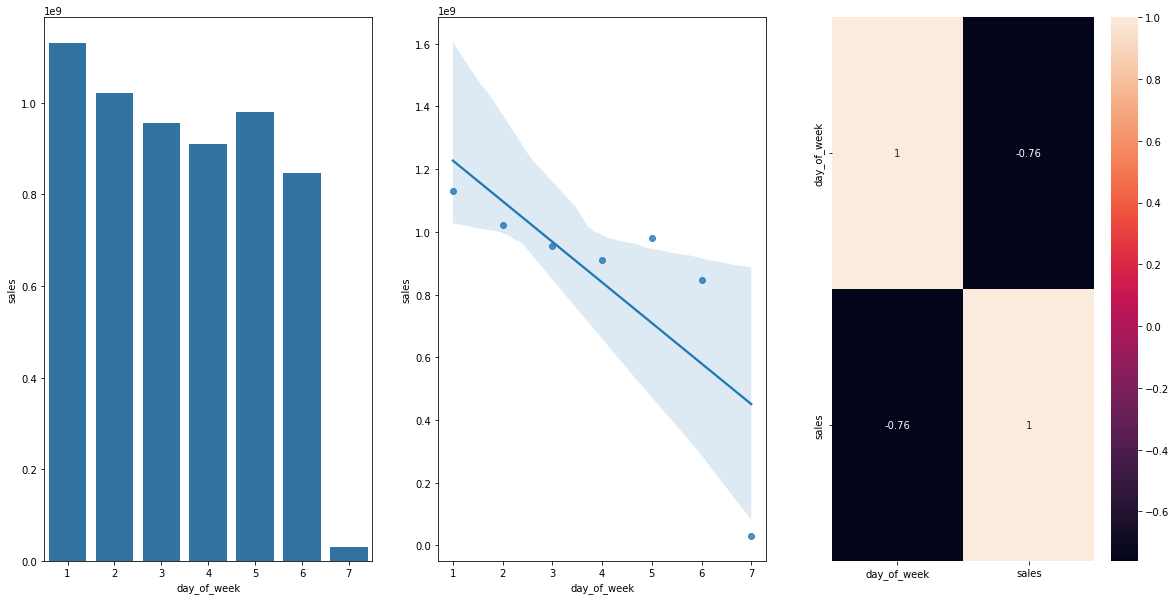

In [81]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

In [82]:
# Este é um método que comprova que o Rossmann usa a segunda como dia 1, a terça como dia 2... e o domingo como dia 7.
df4[['date', 'day_of_week']].sort_values('date').sample(5)

,date,day_of_week
225876,2015-01-10,6
750186,2013-08-28,3
65358,2015-06-03,3
828449,2013-06-19,3
779635,2013-08-02,5


### **H12.** Lojas deveriam vender menos nos feriados escolares.
**VERDADEIRA.** Lojas vendem MENOS durante os FERIADOS ESCOLARES, exceto em agosto.

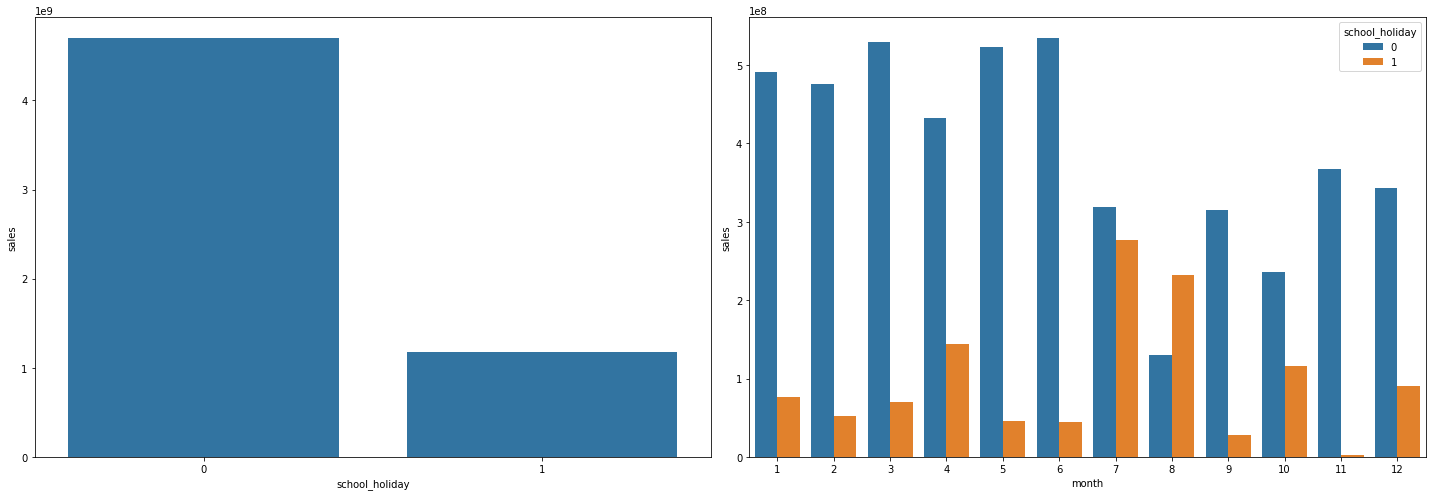

In [83]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

plt.tight_layout()  # Evita sobreposição entre gráficos
plt.show()

O fato de os meses de julho e agosto serem exceções em relação ao restante do ano, pode ser um insight muito valioso para a equipe de negócio.

### 4.2.1 Summary of Hypotheses

In [84]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia' ],
     ['H1', 'Falsa', 'Baixa'],
     ['H2', 'Falsa', 'Media'],
     ['H3', 'Falsa', 'Media'],
     ['H4', 'Falsa', 'Baixa'],
     ['H5', '-', '-'],
     ['H6', 'Falsa', 'Baixa'],
     ['H7', 'Falsa', 'Media'],
     ['H8', 'Falsa', 'Alta'],
     ['H9', 'Falsa', 'Alta'],
     ['H10', 'Verdadeira', 'Alta'],
     ['H11', 'Verdadeira', 'Alta'],
     ['H12', 'Verdadeira', 'Baixa'],
     ]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

In [85]:
num_attributes.head() # relembrando as variaveis numericas do dataset

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


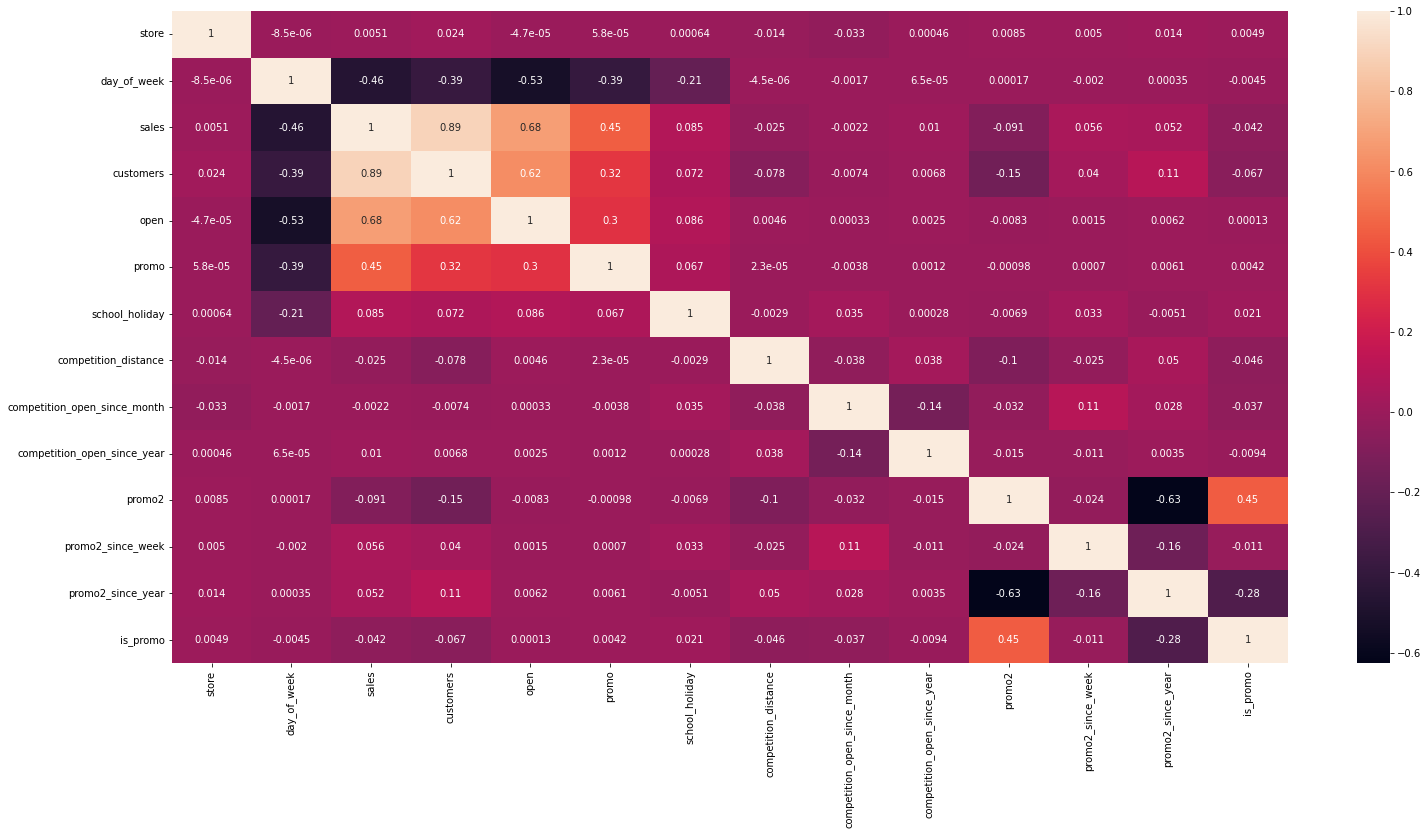

In [86]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(25, 12));
sns.heatmap(correlation, annot=True);
plt.show();

In [87]:
# Sobre o heatmap:
# - é uma matriz simétrica, os dois lados separados pela diagonal são espelhos
# - quanto mais escura a cor, maior a correlação negativa
# - quanto mais clara a cor, maior a correlação positiva

### 4.3.2 Categorical Attributes

In [88]:
a = df4.select_dtypes(include='object')
# aqui tenho que selecionar as variáveis dessa forma pois as variáveis categóricas foram se alterando no decorrer do notebook

In [89]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


- Como o year_week, apesar de estar como variável categórica na verdade é uma data, ficamos com 3 variáveis categóricas a serem relacionadas. Para isso, vamos usar o método Cramér's V.

In [90]:
cm = pd.crosstab(a['state_holiday'], a['store_type']).to_numpy()
# Aqui temos uma tabela de contingência relacionando duas variáveis categóricas.
# Usado o dataset "a", feito para esta análise.
# O to_numpy é usado para visualizar o resultado de cm como uma matriz array. 
cm

array([[     4,     66,      0,      1],
       [    36,    100,      0,      9],
       [   236,    285,     65,    108],
       [456766,  15109, 112903, 258650]])

In [91]:
chi2 = ss.chi2_contingency(cm)[0]
chi2
# Essa função da biblioteca scipy sempre vai retornar 3 valores e um array (teste qui-quadrado, p-value, degrees of freedom,
# matriz de frequências esperadas), mas o Cramers só usa o teste qui-quadrado, então apenas o elemento [0] valerá.

12792.159524019908

In [92]:
# Encontrando os elementos restantes da fórmula do Cramers:
n = cm.sum()
r, k = cm.shape

In [93]:
v = np.sqrt((chi2/n) / (min(k-1, r-1)))
v

0.07106457093267678

Na realidade, o método Cramer é usado como uma função, dessa forma:

In [94]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    return np.sqrt((chi2/n) / (min(k-1, r-1)))

In [95]:
a1 = cramer_v(a['state_holiday'], a['store_type'])
a1

0.07106457093267678

Mas a fórmula do Cramer tem um viés, e para corrigir esse viés, usamos a função dessa forma:

In [96]:
#def cramer_v_corr(x, y):
#    cm = pd.crosstab(x, y).to_numpy()
#    n = cm.sum()
#    r, k = cm.shape
#    
#    chi2 = ss.chi2_contingency(cm)[0]
#    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1)) # Inserido correções chi2coor, kcorr e rcorr.
#    kcorr = k - (k-1)**2/(n-1)
#    rcorr = r - (r-1)**2/(n-1)
#    
#    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

Agora vamos fazer a matriz.

In [97]:
# Calculate cramer V
a1 = cramer_v_corr(a['state_holiday'], a['state_holiday'])
a2 = cramer_v_corr(a['state_holiday'], a['store_type'])
a3 = cramer_v_corr(a['state_holiday'], a['assortment'])

a4 = cramer_v_corr(a['store_type'], a['state_holiday'])
a5 = cramer_v_corr(a['store_type'], a['store_type'])
a6 = cramer_v_corr(a['store_type'], a['assortment'])

a7 = cramer_v_corr(a['assortment'], a['state_holiday'])
a8 = cramer_v_corr(a['assortment'], a['store_type'])
a9 = cramer_v_corr(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3], 
              'store_type': [a4, a5, a6], 
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


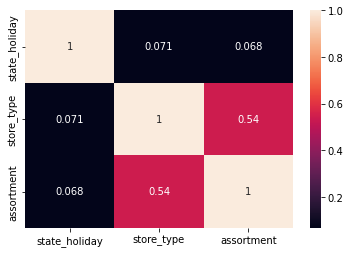

In [98]:
sns.heatmap(d, annot=True);

- Aqui percebemos que as variáveis assortment e store_type têm um grau de correlação maior entre elas, do que com a variável state_holiday, o que se justifica na prática, já que tipo de loja e variedade de estoque são características mais afins.

- Para organização do código, a função cramer_v ficará no início do notebook, na seção imports. Aplicando dessa forma, não será necessário criar a tabela de contingência, pois a função já faz isso.

# 5. DATA PREPARATION

In [99]:
df5 = df4.copy()

## 5.1 Standardization

## 5.2 Normalization

Escolhendo em quais variáveis a data normalization será aplicada.

In [100]:
a1 = df5.select_dtypes(include=['int64', 'float64'])

In [101]:
a1.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,4,0


In [102]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int32
month                                    int32
day                                      int32
week_of_year                            UInt32
year_week                               object
competition_s

In [103]:
# Variáveis escolhidas:

# competition distance
# competition time month
# promo time week
# year

Agora precisamos verificar os outliers das variáveis escolhidas.

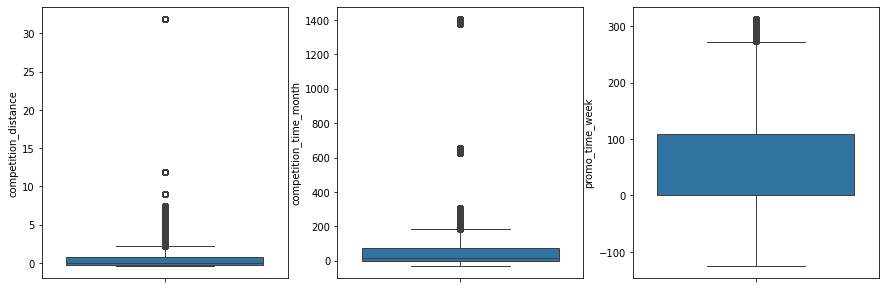

In [114]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(df5['competition_distance']);

plt.subplot(1, 3, 2)
sns.boxplot(df5['competition_time_month']);

plt.subplot(1, 3, 3)
sns.boxplot(df5['promo_time_week']);

Como nós mesmos inserimos outliers na variável competition_distance para eliminar os NA (na seção 1.5 - Fillout NA), sabemos que ela possui outliers fortes (200.000). Logo, usaremos a robust scaler aqui. Competition_time_month também possui outliers fortes e a robust scaler será usada. Já para promo_time_week e year, vamos usar o min-max scaler.

In [117]:
# Instanciando as classes RobustScaler e MinMaxScaler:
rs = RobustScaler()
mms = MinMaxScaler()

In [118]:
# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)   

# RobustScaler().fit_transform(df) encontra os parâmetros da fórmula e aplica nos dados.
# O uso do duplo colchete é necessário para uma saída dataframe (matriz 2D e não series 1D), da forma que o RobustScaler exige.
# Dessa forma, temos a variável em uma nova escala.

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)  

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)  

Agora vamos fazer um plot para verificarmos a transformação do range da competition_distance, como exemplo.

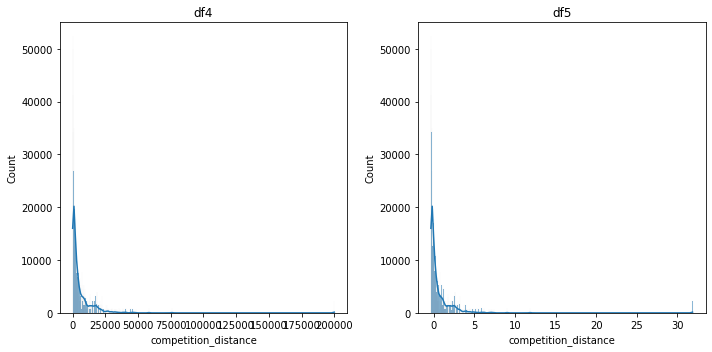

In [127]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(df4['competition_distance'], kde=True)  
plt.title('df4')

plt.subplot(1, 2, 2)
sns.histplot(df5['competition_distance'], kde=True)
plt.title('df5')

plt.tight_layout()
plt.show()

## 5.3 Transformacao

Aplicamos em variáveis numéricas cíclicas.

In [107]:


# day of week
# month
# day
# week of year